## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [191]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/dmel/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/dmel/'
gtf_name = 'Drosophila_melanogaster.BDGP6.32.103.gtf'
mutation = 'Fmr1'
samp_num = '3'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [58]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [7]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

## Determine KS statistic for all transcripts

In [8]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    p_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
            smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
            ks = max(abs(cumul_m - cumul_c))
            n = len(tr_m)
            m = len(tr_c)
            en = (n*m)/(n+m)
            p = kstwo.sf(ks,np.round(en))
            ks_list.append(ks)
            p_list.append(p)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            

    # Calculate the -10 log of the P values in order to visualize the smallest values. 
    log_p = []
    for p in p_list:
        if p != 0:
            log_p.append(math.log(p, 0.1))
        else:
            log_p.append(200)
            
    # reorganizing the lists into a dataframe. 
    df = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, p_list, log_p)))
    df.columns = ["gene_ID","transcript_ID", "ks_stat", "p_value", "-10logp"]
    df.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [192]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

Text(0.5, 1.0, 'KS statistic of all mouse transcripts')

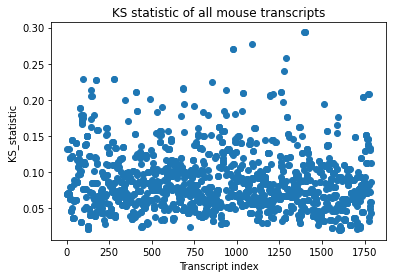

In [193]:
plt.scatter(list(range(len(df["ks_stat"]))), df["ks_stat"])
plt.ylabel("KS_statistic")
plt.xlabel("Transcript index")
plt.title("KS statistic of all mouse transcripts")

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (fly)')

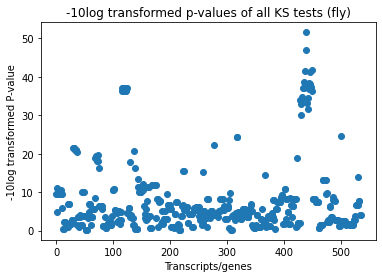

In [220]:
plt.scatter(list(range(len(df["-10logp"]))), df["-10logp"])
plt.ylabel("-10log transformed P-value")
plt.xlabel("Transcripts/genes")
plt.title("-10log transformed p-values of all KS tests (fly)")
#plt.ylim(0,250)
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

In [195]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets.csv')

Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

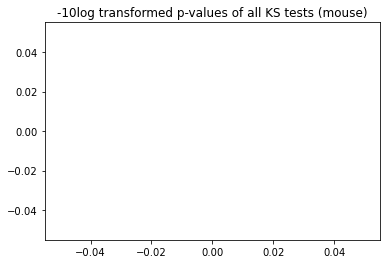

In [196]:
# plot the -10log p_values for the Fmr1 targets
df2 = pd.merge(df, Fmr1_targets, how = "inner", left_on="gene_ID", right_on="FLY")
plt.scatter(list(range(len(df2['-10logp']))), df2['-10logp'])
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

## Observe the count arrays for the genes with the smallest P-value after conducting the KS-test. 

In [224]:
group = df[df['-10logp'] > 30].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['-10logp'].unique())

In [225]:
def big_dif(diff_dist, transcripts, data_mutant, data_control, figsize = (16,50), fontsize = 12):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, logp, gi in zip(ax, diff_dist, diff_dist.index):
            my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts(gi, 
                                           transcripts, data_mutant, data_control)
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/2, maxi/1.2, "-10log(p) = " + str(logp), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + gi, fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()
            
    return ax

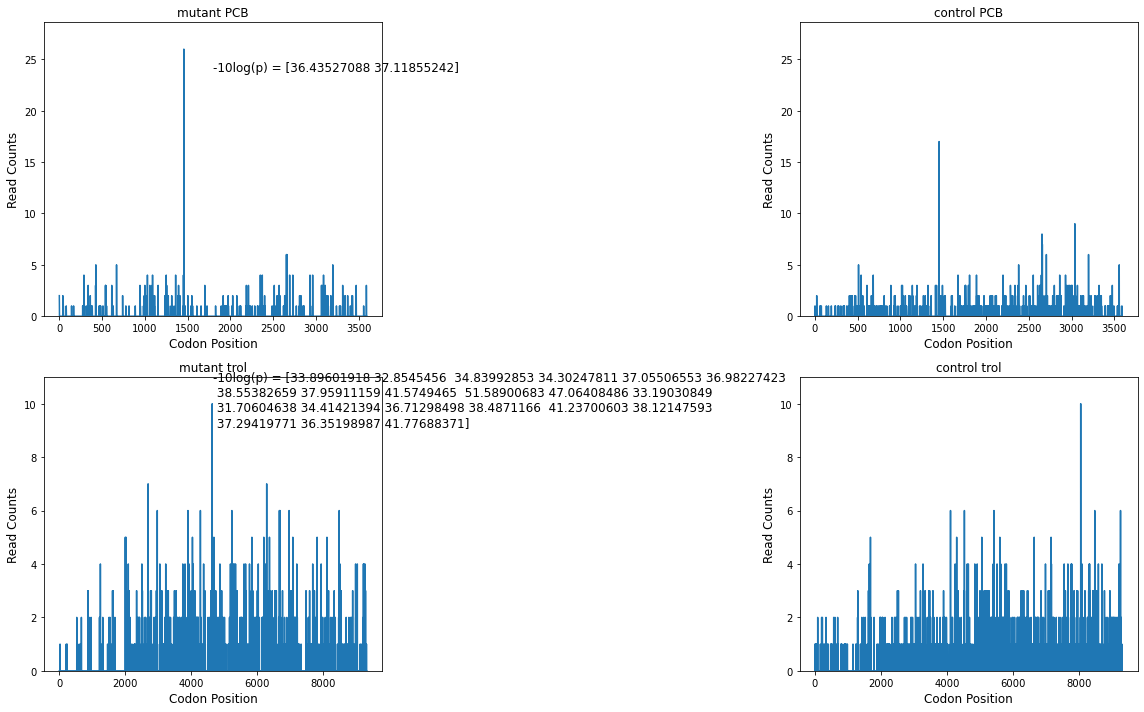

In [226]:
ax = big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,10), fontsize = 12)

## Choose the gene of interest and smooth out the array.

In [17]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts('RpL34a', 
                                           protein_coding, data_mutant, data_control)

In [18]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [19]:
sum(my_vec_control)

421

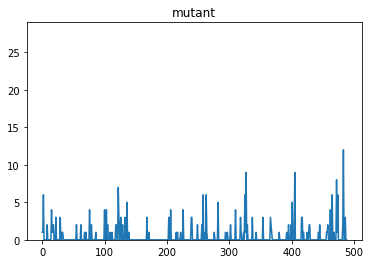

Text(0.5, 1.0, 'control')

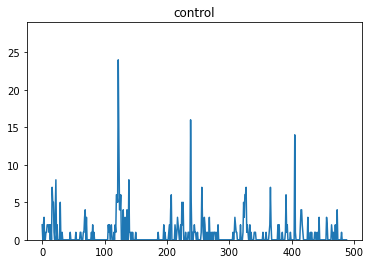

In [20]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.plot(my_vec_mutant)
plt.ylim([0,maxi+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,maxi+5])
plt.title("control")

In [21]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)

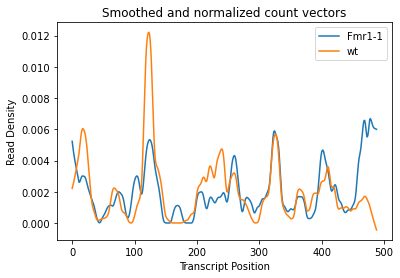

In [22]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

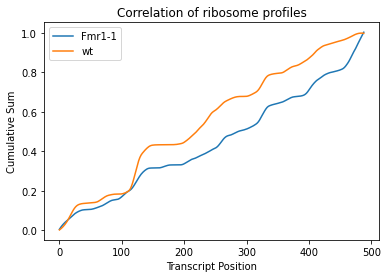

In [23]:
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [24]:
ks = max(abs(cumul_m - cumul_c))
n = len(my_vec_mutant)
m = len(my_vec_control)
en = (n*m)/(n+m)
p = kstwo.sf(ks,np.round(en))

In [25]:
p

2.278909202663603e-08

# Test Area

In [205]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets/Fmr1_dmel_downreg_genes.txt',
                          names = ["gene_name"])

In [206]:
Fmr1_targets["gene_name_lower"] = Fmr1_targets["gene_name"].str.lower()

In [207]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == True:
    ks_list = []
    p_list = []
    gene_list = []
    x=0
    tr_id = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, protein_coding):
        if transcript.attr["gene_name"].lower() in list(Fmr1_targets["gene_name_lower"]):
            x=x+1
            if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.1 and sum(tr_c)/len(tr_c) > 0.1:
                position = np.array(list(range(len(tr_m))))
                smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
                smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
                ks = max(abs(cumul_m - cumul_c))
                n = len(tr_m)
                m = len(tr_c)
                en = (n*m)/(n+m)
                p = kstwo.sf(ks,np.round(en))
                ks_list.append(ks)
                p_list.append(p)
                gene_list.append(transcript.attr["gene_name"])
                tr_id.append(transcript.get_name())
            

    # Calculate the -10 log of the P values in order to visualize the smallest values. 
    log_p = []
    for p in p_list:
        if p != 0:
            log_p.append(math.log(p, 0.1))
        else:
            log_p.append(200)
            
    # reorganizing the lists into a dataframe. 
    df = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, p_list, log_p)))
    df.columns = ["gene_ID","transcript_ID", "ks_stat", "p_value", "-10logp"]
    #df.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

62/300, no good.

In [208]:
x

2556

In [209]:
len(df["gene_ID"].unique())

166

In [210]:
# Load in the table of Fmr1 targets
Fmr1_targets = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/Fmr1_targets/Fmr1_dmel_downreg_genes.txt',
                          names = ["gene_name"])

In [211]:
g_list = []
for transcript in protein_coding:
    g_list.append(transcript.attr["gene_name"])

In [212]:
dfg = pd.DataFrame({"gene_name" : g_list})

In [213]:
dfg["gene_name_lower"] = dfg["gene_name"].str.lower()

In [214]:
Fmr1_targets["gene_name_lower"] = Fmr1_targets["gene_name"].str.lower()

In [215]:
df2 = pd.merge(Fmr1_targets, dfg, how = "inner", on="gene_name_lower")

In [219]:
len(df2.gene_name_lower.unique())

679

In [139]:
for i in Fmr1_targets["gene_name_lower"]:
    if i not in list(df2["gene_name_lower"]):
        print(i)

cha
ef2
cr41602
cg9425
cr45194
cg34362
cg14215
pp2a-b'
cg9153
cg14509
noe
cg5642
cg1104
cg10249
eif4g
cg9821
cg7708
cg43729
cg32000
sema-1a
rbp2
cg17360
cg14786
cg12360
cg10777
acon
cg6498
cg45093
cg42593
cg30497
cg1657
cg10186
bru-3
ubc-e2h
mus210
itp-r83a
fas
eif-4a
cr44357
cg9865
cg8552
cg7852
cg7433
cg43444
cg42492
cg34127
cg31619
cg1444
cg11505
cg11448
cg11138
a2bp1
4ehp


Text(0.5, 1.0, '-10log transformed p-values of all KS tests (mouse)')

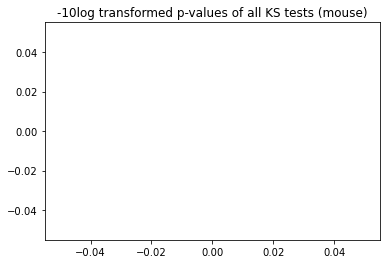

In [13]:
# plot the -10log p_values for the Fmr1 targets
df2 = pd.merge(df, Fmr1_targets, how = "inner", left_on="gene_ID", right_on="FLY")
plt.scatter(list(range(len(df2['-10logp']))), df2['-10logp'])
#plt.ylabel("P-value")
#plt.xlabel("Transcript index")
plt.title("-10log transformed p-values of all KS tests (mouse)")
#plt.plot([0,len(p_list)],[0.506,0.506], "r")

Use Downregulated for both of them. 